In [2]:
import tensorflow
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2003190958323483017,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7175927687443126342
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11386483113664539764
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3160809288145548866
 physical_device_desc: "device: 1, name: GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8786114872414865438
 physical_device_desc: "device: XLA_GPU device",
 name

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers


%matplotlib inline
folder = '../resources/P300/'
mats = []
mats.append(scipy.io.loadmat(folder+'P300S01.mat'))
mats.append(scipy.io.loadmat(folder+'P300S02.mat'))
mats.append(scipy.io.loadmat(folder+'P300S03.mat'))
mats.append(scipy.io.loadmat(folder+'P300S04.mat'))
mats.append(scipy.io.loadmat(folder+'P300S05.mat'))
mats.append(scipy.io.loadmat(folder+'P300S06.mat'))
mats.append(scipy.io.loadmat(folder+'P300S07.mat'))
mats.append(scipy.io.loadmat(folder+'P300S08.mat'))
folder = folder+'*.mat'
files = glob.glob(folder)

In [4]:
#!pip install sklearn

In [2]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [3]:
for mat in mats:
    X = mat['data']['X'][0][0]
    y = mat['data']['y'][0][0]
    flash = mat['data']['flash'][0][0]
    cleaned_X, cleaned_Y = clean_data(X,y,flash)
    
y2=[]
for value in y:
    y2.append(value*50)

NameError: name 'clean_data' is not defined

In [7]:
X.shape

(358372, 8)

In [8]:
flash[0]

array([7486,   31,   11,    1])

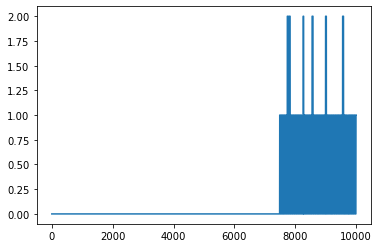

In [9]:
plt.plot(y[0:10000])
plt.show()

NameError: name 'y2' is not defined

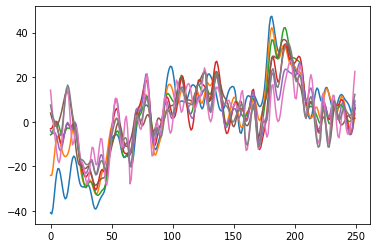

In [10]:
plt.plot(X[7400:7650])
plt.plot(y2[7400:7650])
plt.show()

In [4]:
X_samples = np.array([np.array(X[i[0]:i[0]+351]) for i in flash] )

NameError: name 'flash' is not defined

In [5]:
it= 0
for i in flash:
    plt.plot(X[i[0]:i[0]+351])
    plt.show()
    if it == 5:
        break
    it+=1

NameError: name 'flash' is not defined

In [6]:
def clean_data(X, Y, flash):
  
    X_samples = np.array([np.array(X[i[0]:i[0]+351]) for i in flash] )
    column    = [i[2] for i in flash]
    label     = [i[3] - 1 for i in flash]

    LIMIT = 4080 #the last trial is incomplete
    X_selected = np.array(X_samples[:LIMIT])
    col_selected = np.array(column[:LIMIT])
    label_selected = np.array(label[:LIMIT])

    y = np.array(to_categorical(label_selected))

    false_idx = [k for k, i in enumerate(y) if i[0] == 1]
    true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

    falseX = X_selected[false_idx]
    falsey = y[false_idx]

    trueX  = X_selected[true_idx]  
    truey  = y[true_idx]
    # proportional data to avoid greedy cost funtion

    proportionalX = falseX[:int(len(trueX))]
    proportionaly = falsey[:int(len(truey))]

    finalX = np.concatenate((trueX, proportionalX))
    finaly = np.concatenate((truey, proportionaly))

    X_timeseries = np.vstack(finalX)
    X_letters = X_timeseries.reshape(34,40,351,8)
    y_letters = finaly.reshape(34,40,2)
    cleaned_X = np.vstack(X_letters)
    cleaned_Y = np.vstack(y_letters)

    return cleaned_X, cleaned_Y

In [7]:
def prepare_data(file):
    allX = []
    allY = []
    allT = []
    allF = []
    raw_data = scipy.io.loadmat(file)
    useful_data = raw_data['data'].copy()
    X = useful_data['X']
    Y = useful_data['y']
    T = useful_data['trial']
    F = useful_data['flash']
    # X_mean = np.mean(X, axis=1)
    X_filtered = butter_lowpass_filter(X, cutoff, fs, order)
    return X_filtered, Y, T, F
    #return X, Y, T, F

In [8]:
cleaned_X, cleaned_Y = clean_data(X,y,flash)

In [9]:
cleaned_X.shape

(1360, 351, 8)

In [15]:
input_shape=(351,8,1)
model = Sequential()
model.add(keras.Input(shape = (351,8,1)))
model.add(Conv2D(16, kernel_size=(8,8),padding='same'))
model.add(Conv2D(32, kernel_size=(6,6),padding='same'))
model.add(Conv2D(8, kernel_size=(4,4),padding='same'))
model.add(Conv2D(4, kernel_size=(2,2),padding='same'))

model.add(GlobalMaxPooling2D())
model.add(Dense(10, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(100,activation=tf.nn.softmax))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 351, 8, 16)        1040      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 351, 8, 32)        18464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)               

In [12]:
def get_model2():
    input_layer = keras.Input(shape = (351,8,1), name='main_input')
    x     = layers.Conv2D(16, kernel_size=(8,1), padding='same', activation='relu')(input_layer)
    x     = layers.Conv2D(32, kernel_size=(1,6), padding='same', activation='relu')(x)
    x     = layers.Conv2D(8, 4, padding='same', activation='relu')(x)
    x     = layers.Conv2D(4, 2, padding='same', activation='relu')(x)
    x     = layers.GlobalAveragePooling2D()(x)
    x     = layers.Dense(8)(x)
    x     = layers.Dense(64)(x)
    output = layers.Dense(2, activation='softmax')(x)

    model2 = keras.Model(inputs=input_layer, outputs=output)

    model2.summary()
    return model2

In [17]:
asd = get_model2()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 351, 8, 16)        144       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 351, 8, 32)        3104      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [18]:
input_layer = keras.Input(shape = (351,8,1), name='main_input')
x     = layers.Conv2D(16, 8, padding='same', activation='relu')(input_layer)
x     = layers.Conv2D(32, 6, padding='same', activation='relu')(x)
x     = layers.Conv2D(8, 4, padding='same', activation='relu')(x)
x     = layers.Conv2D(4, 2, padding='same', activation='relu')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

his_model = keras.Model(inputs=input_layer, outputs=output)

his_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 351, 8, 16)        1040      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 351, 8, 32)        18464     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

In [13]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#with strategy.scope():
#    model2=get_model2()
    #compiling the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)  # default params
    #model.compile(optimizer=opt,
    #              loss='binary_crossentropy',
    #              metrics=['accuracy'])
model = get_model2()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 351, 8, 16)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 351, 8, 32)        3104      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_p

In [14]:
appX = []
appy = []

#for file in files:
#    X, Y, Trials, Flash = prepare_data(file)
#    X_clean, y_clean = clean_data(X, Y, Flash)
#    appX.append(X_clean)
#    appy.append(y_clean)

for mat in mats:
    X = mat['data']['X'][0][0]
    y = mat['data']['y'][0][0]
    flash = mat['data']['flash'][0][0]
    cleaned_X, cleaned_Y = clean_data(X,y,flash)      
    appX.append(cleaned_X)
    appy.append(cleaned_Y)

X = [subject for subject in appX]
y = [subject for subject in appy]
X_train, X_valid, y_train, y_valid = train_test_split(np.vstack(X), np.vstack(y), test_size=0.1, random_state=816)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=30, epochs=75, verbose=1)

C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/75
327/327 [==============================] - 4s 11ms/step - loss: 0.6886 - accuracy: 0.5160 - val_loss: 0.6816 - val_accuracy: 0.5285
Epoch 2/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6810 - accuracy: 0.5466 - val_loss: 0.6785 - val_accuracy: 0.5533
Epoch 3/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6759 - accuracy: 0.5684 - val_loss: 0.6584 - val_accuracy: 0.5993
Epoch 4/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6702 - accuracy: 0.5767 - val_loss: 0.6570 - val_accuracy: 0.6075
Epoch 5/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6611 - accuracy: 0.6017 - val_loss: 0.6386 - val_accuracy: 0.6333
Epoch 6/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6496 - accuracy: 0.6207 - val_loss: 0.6251 - val_accuracy: 0.6471
Epoch 7/75
327/327 [==============================] - 3s 10ms/step - loss: 0.6374 - accuracy: 0.6364 - val_loss: 0.6445 - val_accuracy: 0.6066

Epoch 58/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3359 - accuracy: 0.8554 - val_loss: 0.5890 - val_accuracy: 0.7114
Epoch 59/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3491 - accuracy: 0.8490 - val_loss: 0.5300 - val_accuracy: 0.7601
Epoch 60/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3258 - accuracy: 0.8570 - val_loss: 0.5825 - val_accuracy: 0.7638
Epoch 61/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3293 - accuracy: 0.8540 - val_loss: 0.5332 - val_accuracy: 0.7822
Epoch 62/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3357 - accuracy: 0.8561 - val_loss: 0.5419 - val_accuracy: 0.7693
Epoch 63/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3126 - accuracy: 0.8644 - val_loss: 0.6094 - val_accuracy: 0.7776
Epoch 64/75
327/327 [==============================] - 3s 10ms/step - loss: 0.3281 - accuracy: 0.8537 - val_loss: 0.5842 - val_accuracy:

In [28]:
0.8 acc 0.7 val acc a his

SyntaxError: invalid syntax (<ipython-input-28-f7e4f5188f86>, line 1)